Neural Style Transfer

In [1]:
import cv2
import numpy as np
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import tensorflow as tf
from tensorflow.keras.applications import vgg19
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt


# Function to preprocess the image for VGG19
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

# Function to deprocess the image for viewing
def deprocess_image(x):
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# Function to compute content loss
def content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

# Function to compute the gram matrix for style loss
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

# Function to compute style loss
def style_loss(base_style, gram_target):
    batch_size, height, width, channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)
    return tf.reduce_mean(tf.square(gram_style - gram_target)) / (height * width * channels)

# Load the content and style images
content_image = preprocess_image('./images/cat.jpeg')
style_image = preprocess_image('./images/thescream.jpg')

# Load the VGG19 model
model = vgg19.VGG19(weights='imagenet', include_top=False)

# Define the layers to use for the style and content
content_layer = 'block5_conv2'
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

# Create the model for content and style
outputs = [model.get_layer(name).output for name in style_layers + [content_layer]]
style_model = Model(inputs=model.input, outputs=outputs)

# Extract the style and content features
style_outputs = style_model(style_image)
content_outputs = style_model(content_image)

# Compute the style features' Gram matrices
style_grams = [gram_matrix(style_feature) for style_feature in style_outputs]

# Set initial image for optimization
initial_image = tf.Variable(content_image, dtype=tf.float32)

# Define the optimizer
optimizer = tf.optimizers.Adam(learning_rate=5.0)

# Modify the style loss calculation in the optimization loop
for i in range(1, 101):
    with tf.GradientTape() as tape:
        output = style_model(initial_image)
        loss = sum([style_loss(output[j], style_grams[j]) for j in range(len(style_layers))])
        loss += content_loss(output[-1], content_outputs[-1])
    grad = tape.gradient(loss, initial_image)
    optimizer.apply_gradients([(grad, initial_image)])
    if i % 100 == 0:
        print(f'Iteration {i} completed')

# Convert final image to uint8
final_image = deprocess_image(initial_image.numpy()[0])

# Read the input image for replacing background
image = cv2.imread("images/cat.jpeg")

# Check if image was properly loaded
if image is None:
    print("Error: Image not found or could not be opened.")
else:
    # Replace background with white color
    result_image = replace_background(image, new_bg_color=(255, 255, 255))

    # Resize final image to match the replaced background
    final_image_resized = cv2.resize(final_image, (result_image.shape[1], result_image.shape[0]))

    # Convert final image to BGR for OpenCV
    final_image_bgr = final_image_resized[:, :, ::-1]

    # Create a mask for the background
    background_mask = np.all(result_image == [255, 255, 255], axis=-1)

    # Apply style transfer only to the background
    for i in range(3):  # Process each channel separately
        final_image_bgr[..., i] = np.where(background_mask, final_image_bgr[..., i], result_image[..., i])

    # Convert back to RGB
    final_image_rgb = final_image_bgr[:, :, ::-1]

    # Display the result
    cv2.imshow("Original Image", image)
    cv2.imshow("Final Result", final_image_rgb)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # Save the result
    cv2.imwrite("final_result.jpg", final_image_rgb)


Iteration 100 completed


C:\Users\admin\anaconda3\lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Output Model file

In [1]:
import torch
# Save the trained model
output_model_path = "C://Users//admin//Desktop//style_transfer_app//output//trained_model.pth"



Function to make background white

In [ ]:
# Function to replace background with a solid color
def replace_background(image, new_bg_color=(255, 255, 255)):
    cfg = get_cfg()
    cfg.merge_from_file("det/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
    cfg.MODEL.WEIGHTS = output_model_path
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
    predictor = DefaultPredictor(cfg)

    outputs = predictor(image)
    instances = outputs["instances"]

    # Check if instances are detected
    if instances is None or len(instances) == 0:
        print("No instances detected.")
        return None

    # Extract the segmentation masks
    masks = instances.pred_masks.numpy()

    # Apply the masks to the background
    for mask in masks:
        mask = mask.astype(np.uint8)
        # Create a copy of the background for blending
        blended_image = background.copy()
        # Blend the masked image with the background using numpy operations
        blended_image[mask == 1] = (sample_image[mask == 1] * 0.5 + background[mask == 1] * 0.5).astype(np.uint8)
        # Update the background with the blended image
        background = blended_image

    # # Replace the background with white
    # background_color = (255, 255, 255)  # White color
    # background = np.ones(sample_image.shape, dtype=np.uint8) * new_bg_color  

    # # Create a white background image with the same dimensions as input image
    # background = np.ones_like(image, dtype=np.uint8) * new_bg_color

    # Bitwise-AND to get the background
    bg = cv2.bitwise_and(background, background, mask=(1 - mask).astype(np.uint8))

    return bg

Adding Instance Segmentation to the Neural Style Transfer

In [15]:
import cv2
import numpy as np
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import tensorflow as tf
from tensorflow.keras.applications import vgg19
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

#sample_image_path = "./images/shirt.jpeg"

sample_image_path = "C://Users//admin//Desktop//style_transfer_app//static//images//0d293c69-ba4f-4ffc-b6b9-fa05316a02c5.jpg"
sample_image = cv2.imread(sample_image_path)




# Function to preprocess the image for VGG19
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

# Function to deprocess the image for viewing
def deprocess_image(x):
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# Function to compute content loss
def content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

# Function to compute the gram matrix for style loss
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

# Function to compute style loss
def style_loss(base_style, gram_target):
    batch_size, height, width, channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)
    return tf.reduce_mean(tf.square(gram_style - gram_target)) / (height * width * channels)

# Load the content and style images
content_image = preprocess_image(sample_image_path)
#content_image = preprocess_image("./images/shirt.jpeg")
style_image = preprocess_image('./images/thescream.jpg')

# Load the VGG19 model
model = vgg19.VGG19(weights='imagenet', include_top=False)

# Define the layers to use for the style and content
content_layer = 'block5_conv2'
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

# Create the model for content and style
outputs = [model.get_layer(name).output for name in style_layers + [content_layer]]
style_model = Model(inputs=model.input, outputs=outputs)

# Extract the style and content features
style_outputs = style_model(style_image)
content_outputs = style_model(content_image)

# Compute the style features' Gram matrices
style_grams = [gram_matrix(style_feature) for style_feature in style_outputs]

# Set initial image for optimization
initial_image = tf.Variable(content_image, dtype=tf.float32)

# Define the optimizer
optimizer = tf.optimizers.Adam(learning_rate=5.0)

# Modify the style loss calculation in the optimization loop
for i in range(1, 101):
    with tf.GradientTape() as tape:
        output = style_model(initial_image)
        loss = sum([style_loss(output[j], style_grams[j]) for j in range(len(style_layers))])
        loss += content_loss(output[-1], content_outputs[-1])
    grad = tape.gradient(loss, initial_image)
    optimizer.apply_gradients([(grad, initial_image)])
    if i % 100 == 0:
        print(f'Iteration {i} completed')

# Convert final image to uint8
final_image = deprocess_image(initial_image.numpy()[0])

# Read the input image for replacing background
image = cv2.imread("C://Users//admin//Desktop//style_transfer_app//static//images//0d293c69-ba4f-4ffc-b6b9-fa05316a02c5.jpg")
#image = cv2.imread('./images/shirt.jpeg')
# Check if image was properly loaded
if image is None:
    print("Error: Image not found or could not be opened.")
else:
    # # Replace background with white color
    # background = replace_background(sample_image, new_bg_color=(255, 255, 255))

    # cfg = get_cfg()
    # cfg.merge_from_file("det/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
    # cfg.DATASETS.TRAIN = ("shirt_dataset_train",)
    # cfg.DATASETS.TEST = ()  # No test dataset
    # cfg.DATALOADER.NUM_WORKERS = 2
    # cfg.MODEL.WEIGHTS = output_model_path
    # cfg.SOLVER.IMS_PER_BATCH = 2
    # cfg.SOLVER.BASE_LR = 0.0025
    # cfg.SOLVER.MAX_ITER = 50  # You can adjust this
    # cfg.SOLVER.STEPS = []  # You can add learning rate steps here
    # cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  # You can adjust this
    # cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Only one class (Shirt)

    # # Enable mask prediction
    # cfg.MODEL.MASK_ON = True

    # Step 2: Configure and initialize the model for training
    cfg = get_cfg()
    cfg.merge_from_file("detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
    cfg.DATASETS.TRAIN = ("dataset_train",)
    cfg.DATASETS.TEST = ()
    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.WEIGHTS = output_model_path
    cfg.SOLVER.BASE_LR = 0.001  # Adjust the learning rate based on your dataset and model architecture
    cfg.SOLVER.MOMENTUM = 0.9  # Momentum for SGD optimizer
    cfg.SOLVER.WEIGHT_DECAY = 0.0001  # Weight decay for regularization
    cfg.SOLVER.GAMMA = 0.1  # Multiplicative factor for reducing learning rate
    cfg.SOLVER.STEPS = (500, 800)  # Decrease the learning rate at these steps
    cfg.SOLVER.MAX_ITER = 1000  # Total number of iterations for training
    cfg.SOLVER.IMS_PER_BATCH = 2  # Batch size

    cfg.SOLVER.STEPS = []  # You can add learning rate steps here
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  # You can adjust this
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5  # Updated number of classes

    # Enable mask prediction
    cfg.MODEL.MASK_ON = True


    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
    predictor = DefaultPredictor(cfg)

    # Perform inference
    outputs = predictor(sample_image)

    # Get the predicted instances
    instances = outputs["instances"].to("cpu")

    # Print the available fields
    print("Available fields in instances object:", instances.get_fields().keys())

    # Check if 'pred_masks' is available
    if "pred_masks" not in instances.get_fields():
        print("Model does not predict masks!")
    else:
        # Extract the segmentation masks
        masks = instances.pred_masks.numpy()

        # Replace the background with white
        background_color = (255, 255, 255)  # White color
        background = np.ones(sample_image.shape, dtype=np.uint8) * background_color

        # Apply the masks to the background
        # Apply the masks to the background
        for mask in masks:
            mask = mask.astype(np.uint8)
            # Create a copy of the background for blending
            blended_image = background.copy()
            # Replace the masked area with the sample image without blending with the background
            blended_image[mask == 1] = sample_image[mask == 1]
            # Update the background with the blended image
            background = blended_image


        # Save the resulting image
        output_image_path = "output_image3.jpg"
        cv2.imwrite(output_image_path, background)
    
    # # Convert background to uint8
    background_uint8 = background.astype(np.uint8)

    # Resize final image to match the replaced background
    final_image_resized = cv2.resize(final_image, (background.shape[1], background.shape[0]))

    # Convert final image to BGR for OpenCV
    final_image_bgr = final_image_resized[:, :, ::-1]

    # Overlay styled content on replaced background
    final_result = cv2.add(final_image_bgr, background_uint8)

    # Save the instance segmented image
    segmented_image_path = "segmented_image.jpg"
    cv2.imwrite(segmented_image_path, background_uint8)

    # Display the result
    cv2.imshow("Original Image", image)
    cv2.imshow("Final Result", final_result)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # Save the result
    cv2.imwrite("final_result3.jpg", final_result)

Iteration 100 completed
Available fields in instances object: dict_keys(['pred_boxes', 'scores', 'pred_classes', 'pred_masks'])


Original Image

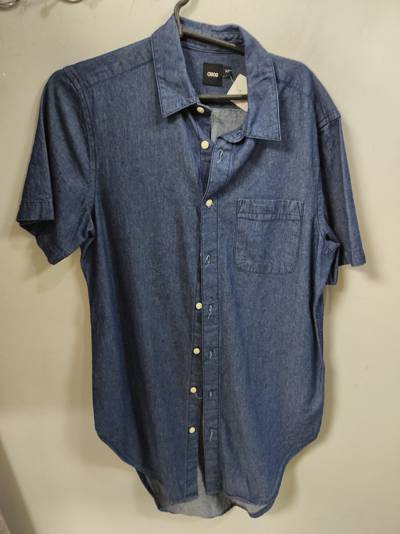

In [18]:
from IPython.display import Image
# Display the output image in Jupyter Notebook
Image(filename="C://Users//admin//Desktop//style_transfer_app//static//images//0d293c69-ba4f-4ffc-b6b9-fa05316a02c5.jpg")

Final Output Image

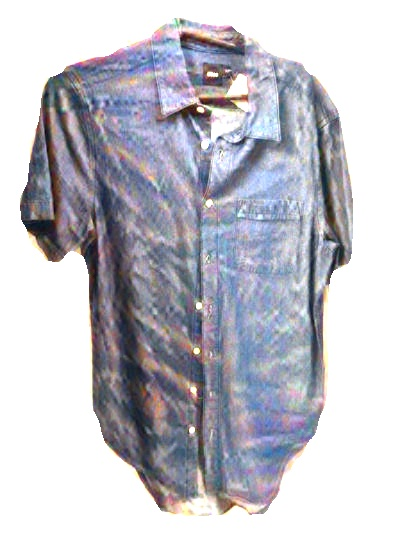

In [16]:
from IPython.display import Image
# Display the output image in Jupyter Notebook
Image(filename=f"C://Users//admin//Desktop//Neural Style Transfers//final_result3.jpg")

Trial and Error

In [10]:
import cv2
import numpy as np
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from tensorflow.keras.applications import vgg19
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

# Function to compute content loss
def content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

# Function to compute the gram matrix for style loss
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

# Function to compute style loss
def style_loss(base_style, gram_target):
    batch_size, height, width, channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)
    return tf.reduce_mean(tf.square(gram_style - gram_target)) / (height * width * channels)

# Function to preprocess the segmented part for VGG19
def preprocess_segmented_part(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

# Function to deprocess the image for viewing
def deprocess_image(x):
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# Load the trained Mask R-CNN model
cfg = get_cfg()
cfg.merge_from_file("detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.WEIGHTS = output_model_path
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)

# Load a sample image
sample_image_path = "C://Users//admin//Desktop//style_transfer_app//static//images//0e3d71f8-7677-4cd4-ba24-4788c3890ac1.jpg"
sample_image = cv2.imread(sample_image_path)

# Perform instance segmentation
outputs = predictor(sample_image)
instances = outputs["instances"].to("cpu")

# Get the predicted segmentation masks
masks = instances.pred_masks.numpy()

# Initialize the background with the original image
background = sample_image.copy()

# Load the VGG19 model
model = vgg19.VGG19(weights='imagenet', include_top=False)

# Define the layers to use for the style and content
content_layer = 'block5_conv2'
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

# Create the model for content and style
outputs = [model.get_layer(name).output for name in style_layers + [content_layer]]
style_model = Model(inputs=model.input, outputs=outputs)

# Extract the content features of the content image
content_image = preprocess_segmented_part(sample_image_path)
content_outputs = style_model(content_image)

# Apply style transfer only to the segmented regions
for mask in masks:
    mask = mask.astype(np.uint8)
    # Extract the segmented part of the image
    segmented_part = sample_image.copy()
    segmented_part[mask == 0] = 0  # Set non-segmented regions to zero

    # Preprocess the segmented part for VGG19
    segmented_part = preprocess_segmented_part(segmented_part)

    # Set initial image for optimization
    initial_image = tf.Variable(segmented_part, dtype=tf.float32)

    # Compute the style features' Gram matrices
    style_outputs = style_model(initial_image)
    style_grams = [gram_matrix(style_feature) for style_feature in style_outputs]

    # Define the optimizer
    optimizer = tf.optimizers.Adam(learning_rate=5.0)

    # Modify the style loss calculation in the optimization loop
    for i in range(1, 101):
        with tf.GradientTape() as tape:
            output = style_model(initial_image)
            loss = sum([style_loss(output[j], style_grams[j]) for j in range(len(style_layers))])
            loss += content_loss(output[-1], content_outputs[-1])
        grad = tape.gradient(loss, initial_image)
        optimizer.apply_gradients([(grad, initial_image)])
        if i % 100 == 0:
            print(f'Iteration {i} completed')

    # Convert final image to uint8
    final_image = deprocess_image(initial_image.numpy()[0])

    # Overlay styled content on the background
    background[mask == 1] = final_image

# Save the resulting image
output_image_path = "output_image_segmented_style_transfer.jpg"
cv2.imwrite(output_image_path, background)


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (6, 1024) in the checkpoint but (81, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (6,) in the checkpoint but (81,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (20, 1024) in the checkpoint but (320, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (20,) in the checkpoint but (320,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (5, 256, 1, 1) in the checkpoint but (80, 256, 1, 1) 

True

In [1]:
import cv2
# Load a sample image
# sample_image_path = "C://Users//admin//Desktop//New folder//images//00e745c9-97d9-429d-8c3f-d3db7a2d2991.jpg"
sample_image_path = "./images/shirt.jpeg"
sample_image = cv2.imread(sample_image_path)

In [1]:
import torch
# Save the trained model
#output_model_path = "C://Users//admin//Desktop//Neural Style Transfers//output//trained_model.pth"
output_model_path = "C://Users//admin//Desktop//Neural Style Transfers//output_4//trained_model.pth"


In [ ]:
# Perform inference
outputs = predictor(sample_image)

# Get the predicted instances
instances = outputs["instances"].to("cpu")

# Print the available fields
print("Available fields in instances object:", instances.get_fields().keys())

# Check if 'pred_masks' is available
if "pred_masks" not in instances.get_fields():
    print("Model does not predict masks!")
else:
    # Extract the segmentation masks
    masks = instances.pred_masks.numpy()

    # Replace the background with white
    background_color = (255, 255, 255)  # White color
    background = np.ones(sample_image.shape, dtype=np.uint8) * background_color

    # Apply the masks to the background
    for mask in masks:
        mask = mask.astype(np.uint8)
        # Create a copy of the background for blending
        blended_image = background.copy()
        # Blend the masked image with the background using numpy operations
        blended_image[mask == 1] = (sample_image[mask == 1] * 0.5 + background[mask == 1] * 0.5).astype(np.uint8)
        # Update the background with the blended image
        background = blended_image

    # Save the resulting image
    output_image_path = "output_image.jpg"
    cv2.imwrite(output_image_path, background)


In [8]:
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
import numpy as np


cfg = get_cfg()
cfg.merge_from_file("det/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("shirt_dataset_train",)
cfg.DATASETS.TEST = ()  # No test dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = output_model_path
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0025
cfg.SOLVER.MAX_ITER = 50  # You can adjust this
cfg.SOLVER.STEPS = []  # You can add learning rate steps here
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  # You can adjust this
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Only one class (Shirt)

# Enable mask prediction
cfg.MODEL.MASK_ON = True


cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set a threshold for this model
predictor = DefaultPredictor(cfg)
# Perform inference
outputs = predictor(sample_image)

# Get the predicted instances
instances = outputs["instances"].to("cpu")

# Print the available fields
print("Available fields in instances object:", instances.get_fields().keys())

# Check if 'pred_masks' is available
if "pred_masks" not in instances.get_fields():
    print("Model does not predict masks!")
else:
    # Extract the segmentation masks
    masks = instances.pred_masks.numpy()

    # Replace the background with white
    background_color = (255, 255, 255)  # White color
    background = np.ones(sample_image.shape, dtype=np.uint8) * background_color

    # Apply the masks to the background
    for mask in masks:
        mask = mask.astype(np.uint8)
        # Create a copy of the background for blending
        blended_image = background.copy()
        # Blend the masked image with the background using numpy operations
        blended_image[mask == 1] = (sample_image[mask == 1] * 0.5 + background[mask == 1] * 0.5).astype(np.uint8)
        # Update the background with the blended image
        background = blended_image

    # Save the resulting image
    output_image_path = "output_image1.jpg"
    cv2.imwrite(output_image_path, background)


c:\Users\admin\Desktop\Neural Style Transfers\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(
c:\Users\admin\Desktop\Neural Style Transfers\detectron2\layers\wrappers.py:127: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  x = F.conv2d(
c:\Users\admin\anaconda3\lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3588.)
  

Available fields in instances object: dict_keys(['pred_boxes', 'scores', 'pred_classes', 'pred_masks'])
